In [3]:
import os
import json

import numpy as np

import pickle 
from datetime import datetime as dt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import spacy
from spacy.tokens import DocBin
from spacy.training import Example
import random

2024-03-16 13:35:44.824295: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 13:35:44.824347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 13:35:44.825183: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-16 13:35:44.831546: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-16 13:35:45.707909: W tensorflow/compiler/tf2

In [4]:
from training_utils import load_data, evaluate_spacy, extract_tokens_and_labels, compute_ner_metrics

## Constants
*Defining constants upfront for easy configuration and maintenance.*

In [5]:
DATA_PATH = '/data/02_training_data/'
MODEL_NAME = "en_core_sci_sm"
OUTPUT_DIR = '/data/03_models/finetuned/scispacy/temp' + dt.now().strftime('%d%m%Y_%H-%M-%S')

## Dataset Preparation

### Load the Dataset

In [6]:
try:
    train = load_data(os.path.join(DATA_PATH,'temp_train_NER.pickle'))
    test = load_data(os.path.join(DATA_PATH,'temp_test_NER.pickle'))
except FileNotFoundError as e:
    print(e)

## Finetune SciSpacy
### Load Spacy Model

In [7]:
# Load the spaCy model (choose an appropriate SciSpacy model)
nlp = spacy.load(MODEL_NAME)

/home/bernards/sRNA_extraction/srna_venv/lib/python3.10/site-packages/spacy/language.py:2141: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


### Define `OUTPUT_PATH` for saving model weights

In [8]:
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
    print(f'Output Directory was created: {OUTPUT_DIR}')
else:
    print(f'Output Directory already exists: {OUTPUT_DIR}')

Output Directory was created: /data/03_models/finetuned/scispacy/temp16032024_13-35-46


In [9]:
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]

num_iterations = 50
dropout_rate = 0.2


# Training with Validation
with nlp.disable_pipes(*other_pipes):  # Only train NER
    optimizer = nlp.resume_training()
    for iteration in range(num_iterations):  # Adjust the number of iterations as needed
        random.shuffle(train)
        losses = {}

        # Training loop
        for batch in spacy.util.minibatch(train, size=5):
            examples = []
            for doc in batch:
                examples.append(Example.from_dict(doc, {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}))
            nlp.update(examples, drop=dropout_rate, losses=losses, sgd=optimizer)  # Adjust the dropout rate as needed
        print(f"Iteration {iteration+1}/{num_iterations} - Losses: {losses}")

# Save the trained model
nlp.to_disk(OUTPUT_DIR)

Iteration 1/50 - Losses: {'ner': 261.3531472854969}
Iteration 2/50 - Losses: {'ner': 140.7252432396317}
Iteration 3/50 - Losses: {'ner': 95.02176773748033}
Iteration 4/50 - Losses: {'ner': 65.97454302346796}
Iteration 5/50 - Losses: {'ner': 43.0626168343215}
Iteration 6/50 - Losses: {'ner': 23.437921768257016}
Iteration 7/50 - Losses: {'ner': 10.061792325726746}
Iteration 8/50 - Losses: {'ner': 5.199140714985662}
Iteration 9/50 - Losses: {'ner': 0.881143697604981}
Iteration 10/50 - Losses: {'ner': 0.5015821279300581}
Iteration 11/50 - Losses: {'ner': 0.7355819332674007}
Iteration 12/50 - Losses: {'ner': 2.3918663200489814}
Iteration 13/50 - Losses: {'ner': 0.01157729097152262}
Iteration 14/50 - Losses: {'ner': 0.0015321251246366687}
Iteration 15/50 - Losses: {'ner': 0.018901391637993897}
Iteration 16/50 - Losses: {'ner': 0.00046029576612943707}
Iteration 17/50 - Losses: {'ner': 0.00027021882838726657}
Iteration 18/50 - Losses: {'ner': 0.3614975805016767}
Iteration 19/50 - Losses: {'ner

## Evaluate the model on the test dataset

In [10]:
evaluation_results = evaluate_spacy(nlp, test)

# Print the evaluation results
print("Precision:", evaluation_results["ents_p"])
print("Recall:", evaluation_results["ents_r"])
print("F1-score:", evaluation_results["ents_f"])

Precision: 0.7727272727272727
Recall: 1.0
F1-score: 0.8717948717948718


In [11]:
ground_truth_tokens, ground_truth_labels = extract_tokens_and_labels(test)
predicted_tokens, predicted_labels = extract_tokens_and_labels([nlp(t.text) for t in test])

In [12]:
# Get unique tokens and labels to define the confusion matrix
unique_tokens = np.unique(ground_truth_tokens + predicted_tokens)
unique_labels = np.unique(ground_truth_labels + predicted_labels)

In [13]:
metrics = compute_ner_metrics(predicted_labels, ground_truth_labels)

print("Precision:", metrics["precision"])
print("Recall:", metrics["recall"])
print("F1-Score:", metrics["f1"])
print("\nClassification Report:\n", metrics["classification_report"])

Precision: 0.9372454585357857
Recall: 0.9288256227758007
F1-Score: 0.9320200293255708

Classification Report:
               precision    recall  f1-score   support

           O       0.97      0.96      0.96       246
        SRNA       0.94      0.79      0.86        19
  TARGETGENE       0.48      0.62      0.54        16

    accuracy                           0.93       281
   macro avg       0.79      0.79      0.79       281
weighted avg       0.94      0.93      0.93       281



In [14]:
# Compute the confusion matrix for tokens and labels
cm = confusion_matrix(ground_truth_labels, predicted_labels, labels=["O", "TARGETGENE", "SRNA"])

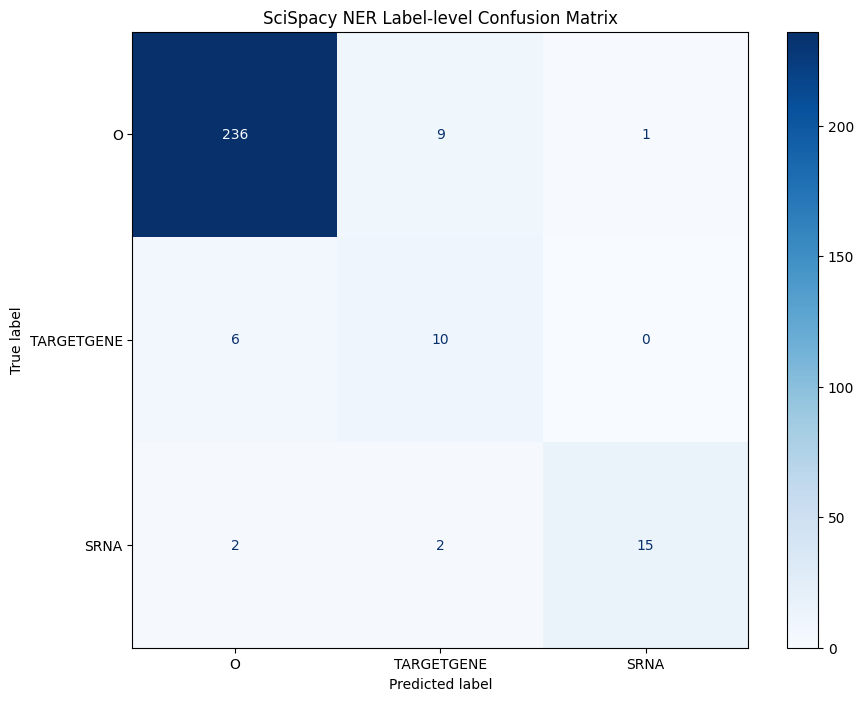

<Figure size 640x480 with 0 Axes>

In [15]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
plt.xlabel('Predicted Labels')
plt.ylabel('Ground Truth Labels')
plt.title('SciSpacy NER Label-level Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["O", "TARGETGENE", "SRNA"])
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()


plt.tight_layout()

In [16]:
cm

array([[236,   9,   1],
       [  6,  10,   0],
       [  2,   2,  15]])